<a href="https://colab.research.google.com/github/hailusong/colab-god-idclass/blob/master/god_idclass_colabtrain_dlib.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training: Train Dlib to Detect Key Points of ID

**FIRST OF ALL: CHOOSE RUNTIME ENVIRONMENT TYPE TO BE GPU**<br>
Environment variables setup.<br>
**Tensorflow runtime version list** can be found at [here](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)

In [0]:
DEFAULT_HOME='/content'
TF_RT_VERSION='1.13'
PYTHON_VERSION='3.5'

YOUR_GCS_BUCKET='id-norm'
YOUR_PROJECT='orbital-purpose-130316'

Dlib and dependents

In [0]:
import cv2
import dlib

## Session and Environment Verification (Destination - Local)

Establish security session with Google Cloud

In [0]:
from google.colab import auth
auth.authenticate_user()


################# RE-RUN ABOVE CELLS IF NEED TO RESTART RUNTIME #################

Verify Versions: TF, Python, IPython and prompt_toolkit (these two need to have compatible version), and protoc

In [4]:
import tensorflow as tf
print(tf.__version__)
assert(tf.__version__.startswith(TF_RT_VERSION + '.')), f'tf.__version__ {tf.__version__} not matching with specified TF runtime version env variable {TF_RT_VERSION}'

1.13.1


In [5]:
!python -V
!ipython --version
!pip show prompt_toolkit
!protoc --version

Python 3.6.7
5.5.0
Name: prompt-toolkit
Version: 1.0.16
Summary: Library for building powerful interactive command lines in Python
Home-page: https://github.com/jonathanslenders/python-prompt-toolkit
Author: Jonathan Slenders
Author-email: UNKNOWN
License: UNKNOWN
Location: /usr/local/lib/python3.6/dist-packages
Requires: six, wcwidth
Required-by: jupyter-console, ipython
libprotoc 3.0.0


## Git Sync for any Change in colab-god-idclass 

In [6]:
![ -e {DEFAULT_HOME}/colab-god-idclass ] && git -C {DEFAULT_HOME}/colab-god-idclass pull
![ ! -e {DEFAULT_HOME}/colab-god-idclass ] && git clone --depth=1 https://github.com/hailusong/colab-god-idclass.git {DEFAULT_HOME}/colab-god-idclass

Cloning into '/content/colab-god-idclass'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 30 (delta 7), reused 9 (delta 0), pack-reused 0
Unpacking objects: 100% (30/30), done.


Push the latest pipeline config file to the GCS

### Download all bboxes and points CSV data

In [7]:
import os
os.chdir(f'{DEFAULT_HOME}')
!pwd

/content


In [8]:
# Download the file.
![[ ! -f /tmp/generated.tar.gz ]] && gsutil cp gs://{YOUR_GCS_BUCKET}/generated.tar.gz /tmp/generated.tar.gz
!ls /tmp/*gz

Copying gs://id-norm/generated.tar.gz...
| [1 files][131.2 MiB/131.2 MiB]                                                
Operation completed over 1 objects/131.2 MiB.                                    
/tmp/generated.tar.gz


In [9]:
![[ ! -f /tmp/generated.tar && -f /tmp/generated.tar.gz ]] && gunzip /tmp/generated.tar.gz
![[ ! -e ./generated && -f /tmp/generated.tar ]] && tar xf /tmp/generated.tar
!pwd
!ls {DEFAULT_HOME}/generated

/content
bbox-train-non-id1.csv	bbox-valid-on-dl.csv	pnts-valid-non-id2.csv
bbox-train-non-id2.csv	bbox-valid-on-hc.csv	pnts-valid-non-id3.csv
bbox-train-non-id3.csv	pnts-train-non-id1.csv	pnts-valid-on-dl.csv
bbox-train-on-dl.csv	pnts-train-non-id2.csv	pnts-valid-on-hc.csv
bbox-train-on-hc.csv	pnts-train-non-id3.csv	Train
bbox-valid-non-id1.csv	pnts-train-on-dl.csv	Valid
bbox-valid-non-id2.csv	pnts-train-on-hc.csv
bbox-valid-non-id3.csv	pnts-valid-non-id1.csv


## Setup Training Data and Validation Data

In [10]:
import os
os.chdir(f'{DEFAULT_HOME}/colab-god-idclass')
!pwd

# soft link to fix path issue - not required anymore
# ![ ! -e generated ] && ln -s {DEFAULT_HOME}/generated ./generated

/content/colab-god-idclass


In [11]:
!pip install fire

  Stored in directory: /root/.cache/pip/wheels/2a/1a/4d/6b30377c3051e76559d1185c1dbbfff15aed31f87acdd14c22
Successfully built fire


Generate Dlib training XML using training CSV data

In [12]:
!python {DEFAULT_HOME}/colab-god-idclass/src/keypoints/generate_dlibxml.py generate "{DEFAULT_HOME}/generated/bbox-train-*" {DEFAULT_HOME}/generated/dlib_train.xml ..
# !head {DEFAULT_HOME}/generated/dlib_train.xml
!python {DEFAULT_HOME}/colab-god-idclass/src/keypoints/generate_dlibxml.py generate "{DEFAULT_HOME}/generated/bbox-train-*" {DEFAULT_HOME}/generated/dlib_train_sameimg.xml .. True
# !head {DEFAULT_HOME}/generated/dlib_train_sameimg.xml

working on /content/generated/bbox-train-non-id1.csv and /content/generated/pnts-train-non-id1.csv
working on /content/generated/bbox-train-on-dl.csv and /content/generated/pnts-train-on-dl.csv
working on /content/generated/bbox-train-on-hc.csv and /content/generated/pnts-train-on-hc.csv
working on /content/generated/bbox-train-non-id2.csv and /content/generated/pnts-train-non-id2.csv
working on /content/generated/bbox-train-non-id3.csv and /content/generated/pnts-train-non-id3.csv
Payload XML count: 5868, total image count: 978.0
<?xml version='1.0' encoding='ISO-8859-1'?>
<?xml-stylesheet type='text/xsl' href='image_metadata_stylesheet.xsl'?>
<dataset>
<name>idclass</name>
<comment>data is for /content/generated/dlib_train.xml</comment>
<images>
  <image file='../generated/Train/non-id1/0.png'>
    <box top='0' left='0' height='97' width='152'>
      <part name='0' x='10' y='9'/>
      <part name='1' x='23' y='90'/>
working on /content/generated/bbox-train-non-id1.csv and /content/ge

Generate Dlib validation XML using validation CSV data.<br>
Note that we generate two validation XML files: one with bboxes **ALWAYS** set to the same as image, and one with bboxes using data from CSV data.

In [13]:
!python {DEFAULT_HOME}/colab-god-idclass/src/keypoints/generate_dlibxml.py generate "{DEFAULT_HOME}/generated/bbox-valid-*" {DEFAULT_HOME}/generated/dlib_test.xml ..
# !head {DEFAULT_HOME}/generated/dlib_test.xml
!python {DEFAULT_HOME}/colab-god-idclass/src/keypoints/generate_dlibxml.py generate "{DEFAULT_HOME}/generated/bbox-valid-*" {DEFAULT_HOME}/generated/dlib_test_sameimg.xml .. True
# !head {DEFAULT_HOME}/generated/dlib_test_sameimg.xml

working on /content/generated/bbox-valid-non-id2.csv and /content/generated/pnts-valid-non-id2.csv
working on /content/generated/bbox-valid-on-dl.csv and /content/generated/pnts-valid-on-dl.csv
working on /content/generated/bbox-valid-non-id3.csv and /content/generated/pnts-valid-non-id3.csv
working on /content/generated/bbox-valid-on-hc.csv and /content/generated/pnts-valid-on-hc.csv
working on /content/generated/bbox-valid-non-id1.csv and /content/generated/pnts-valid-non-id1.csv
Payload XML count: 1464, total image count: 244.0
working on /content/generated/bbox-valid-non-id2.csv and /content/generated/pnts-valid-non-id2.csv
working on /content/generated/bbox-valid-on-dl.csv and /content/generated/pnts-valid-on-dl.csv
working on /content/generated/bbox-valid-non-id3.csv and /content/generated/pnts-valid-non-id3.csv
working on /content/generated/bbox-valid-on-hc.csv and /content/generated/pnts-valid-on-hc.csv
working on /content/generated/bbox-valid-non-id1.csv and /content/generated

## Preview Some Data

### Helper Functions

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

def preview(img_fn:str, rect:list, markers_x:list, markers_y:list):
    """
    rect:
        (x, y, width, height)
    
    markers_x/y:
        (x0, x1, ...)
        (y0, y1, ...)
    """
    im = np.array(Image.open(img_fn), dtype=np.uint8)

    # create figure and axes
    fig ,ax = plt.subplots(1)

    # display the image
    ax.imshow(im)

    # create a Rectangle patch
    rect = patches.Rectangle(rect[:2], *rect[2:], linewidth=1, edgecolor='r', facecolor='none')

    # add the patch to the Axes
    ax.add_patch(rect)

    # markers
#     plt.annotate('25, 50', xy=(25, 50), xycoords='data',
#              xytext=(0.5, 0.5), textcoords='figure fraction',
#              arrowprops=dict(arrowstyle="->"))
    plt.scatter(markers_x, markers_y, c='red', marker='o')

    plt.show()

### Preview

In [15]:
!head  {DEFAULT_HOME}/generated/dlib_train.xml

<?xml version='1.0' encoding='ISO-8859-1'?>
<?xml-stylesheet type='text/xsl' href='image_metadata_stylesheet.xsl'?>
<dataset>
<name>idclass</name>
<comment>data is for /content/generated/dlib_train.xml</comment>
<images>
  <image file='../generated/Train/non-id1/0.png'>
    <box top='0' left='0' height='97' width='152'>
      <part name='0' x='10' y='9'/>
      <part name='1' x='23' y='90'/>


In [0]:
# Pick one image to show in the top 100
import random
img_picked = random.randint(0, 100)

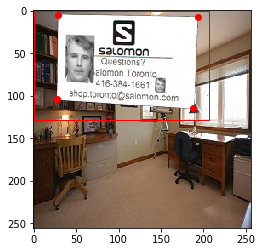

In [17]:
import xml.etree.ElementTree as et

root = et.parse(f'{DEFAULT_HOME}/generated/dlib_train.xml').getroot()

image = root.findall('images/image')[img_picked]
img_fn = image.get('file')
box = image.find('box')
box_top= box.get('top')
box_left = box.get('left')
box_width = box.get('width')
box_height = box.get('height')
# print(f'{img_fn}: {box_top}/{box_left}/{box_width}/{box_height}')

parts_x = []
parts_y = []
for part in box.findall('part'):
    parts_x.append(float(part.get('x')))
    parts_y.append(float(part.get('y')))

preview(img_fn, (float(box_left), float(box_top), float(box_width), float(box_height)), parts_x, parts_y)


## Start the Training and Evaluation Jobs

### Option 2: Start the Training Job on CoLab
Some empirical data (see also http://dlib.net/train_shape_predictor.py.html and [Training alternative Dlib Shape Predictor models using Python](https://medium.com/datadriveninvestor/training-alternative-dlib-shape-predictor-models-using-python-d1d8f8bd9f5c)):
 
 | cascade_depth | feature_pool_size | num_test_splits | oversampling_amount | nu | tree depth | error |
 | - | - | - | - | - | - | - |
 |15 |  400 | 50 | 5 | 0.1 | 4 | ~20 |
 | 15 | 800 | 200 | 5 | 0.1 | 4 | ~10 |
 | 15 | 1000 | 200 | 5 | 0.1 | 4 | ~10 |
 | 15 | 800 | 200 | 10 | 0.05 | 4 | ~9 |
 | 15 | 800 | 200 | 20 | 0.1 | 4 | ~9 |
 | 15 | 800 | 200 | 10 | 0.05 | 3 | ~9 |
 | 15 | 800 | 200 | 10 | 0.02 | 2 | ~10 |

In [0]:
NU=0.1
TREE_DEPTH=4
CASCADE_DEPTH=15
FEATURE_POOL_SIZE=800
NUM_TEST_SPLITS=200
OVERSAMPLING_AMT=10

In [0]:
def train_model(name, xml):
    '''
    requires: the model name, and the path to the xml annotations.
    It trains and saves a new model according to the specified
    training options and given annotations

    example @ https://github.com/Luca96/dlib-minified-models/tree/master/face_landmarks:
      options = dlib.shape_predictor_training_options()
      options.tree_depth = 4
      options.nu = 0.1
      options.cascade_depth = 15
      options.feature_pool_size = 800  # or even 1000
      options.num_test_splits =   # 150-200 is enough
    '''
    # get the training options
    options = dlib.shape_predictor_training_options()
    # same principle as nu
    options.tree_depth = TREE_DEPTH
    # smaller -> increase regularization -> reduce model capacity (avoid underfitting on smaller dataset)
    options.nu = NU
    options.cascade_depth = CASCADE_DEPTH
    options.feature_pool_size = FEATURE_POOL_SIZE
    options.num_test_splits = NUM_TEST_SPLITS
    # larger for small dataset (boosting dataset size)
    options.oversampling_amount = OVERSAMPLING_AMT
 
    # tells what is happening during the training
    options.be_verbose = True
    # number of the threads used to train the model
    options.num_threads = 8

    # finally, train the model
    dlib.train_shape_predictor(xml, name, options)


def measure_model_error(model, xml_annotations):
    '''requires: the model and xml path.
    It measures the error of the model on the given
    xml file of annotations.'''
    error = dlib.test_shape_predictor(xml_annotations, model)
    print("Error of the model: {} is {}".format(model, error))

### Start to train
Note that we have to use bbox data to hint the dlib ERT algorithm the location of the target object for key points detection. One experiment did before to use full image as bbox during training generated poor test result:

> **Test with real bbox data**<br>
> Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 26.387785880448575<br>
> **Test with full image as bbox data**<br>
> Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 20.081601729385024<br>

In contrast, training using real bbox data generated good test result:

> **Test with real bbox data**<br>
> Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 9.208878028068954<br>
> **Test with full image as bbox data**<br>
> Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 57.565112722234524<br>


In [0]:
# train a new model with a subset of the ibug annotations
id_keypoints_train_xml = f'{DEFAULT_HOME}/generated/dlib_train.xml'
id_keypoints_train_sameimg_xml = f'{DEFAULT_HOME}/generated/dlib_train_sameimg.xml'
id_keypoints_test_xml = f'{DEFAULT_HOME}/generated/dlib_test.xml'
id_keypoints_test_sameimg_xml = f'{DEFAULT_HOME}/generated/dlib_test_sameimg.xml'
id_keypoints_fname = f'id_keypoints_dlib_nu{NU}td{TREE_DEPTH}cd{CASCADE_DEPTH}fp{FEATURE_POOL_SIZE}nt{NUM_TEST_SPLITS}oa{OVERSAMPLING_AMT}.dat'
id_keypoints_dat = f'{DEFAULT_HOME}/generated/{id_keypoints_fname}'

In [0]:
# finally train the eye model
train_model(id_keypoints_dat, id_keypoints_train_xml)
# train_model(id_keypoints_dat, id_keypoints_train_sameimg_xml)

In [22]:
# ..and measure the model error on the testing annotations:
# the first one is using real bboxes data and the second one is using full image as bbox
measure_model_error(id_keypoints_dat, id_keypoints_test_xml)
measure_model_error(id_keypoints_dat, id_keypoints_test_sameimg_xml)

Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 26.387785880448575
Error of the model: /content/generated/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat is 20.081601729385024


Upload to GCS

In [0]:
!gsutil cp {id_keypoints_dat} gs://{YOUR_GCS_BUCKET}/id_keypoints_fname

Copying file:///content/generated/id_keypoints.dat [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/7.3 MiB.                                      


## Download the Trained Dlib Model

In [0]:
id_keypoints_fname = f'id_keypoints_dlib_nu{NU}td{TREE_DEPTH}cd{CASCADE_DEPTH}fp{FEATURE_POOL_SIZE}nt{NUM_TEST_SPLITS}oa{OVERSAMPLING_AMT}.dat'
id_keypoints_dat = f'{DEFAULT_HOME}/generated/{id_keypoints_fname}'

!gsutil cp gs://{YOUR_GCS_BUCKET}/{id_keypoints_fname} {id_keypoints_dat}

Copying gs://id-norm/id_keypoints_dlib_nu0.1td4cd15fp800nt200oa10.dat...
- [1 files][  7.3 MiB/  7.3 MiB]                                                
Operation completed over 1 objects/7.3 MiB.                                      


## Inference with Dlib
Reference: https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/

Load trained model

In [0]:
predictor = dlib.shape_predictor(id_keypoints_dat)

Pick one image from test dataset

In [0]:
# Pick one image to show in the top 100
import random
img_picked = random.randint(0, 100)

In [0]:
import xml.etree.ElementTree as et

root = et.parse(f'{DEFAULT_HOME}/generated/dlib_test.xml').getroot()

image = root.findall('images/image')[img_picked]
img_fn = image.get('file')
box = image.find('box')
box_top= int(box.get('top'))
box_left = int(box.get('left'))
box_width = int(box.get('width'))
box_height = int(box.get('height'))
print(f'{img_fn}: {box_top}/{box_left}/{box_width}/{box_height}')
#
# parts_x = []
# parts_y = []
# for part in box.findall('part'):
#     parts_x.append(float(part.get('x')))
#     parts_y.append(float(part.get('y')))


../generated/Valid/on-dl/71.png: 27/34/179/120


Inference ...

In [0]:
# determine the facial landmarks for the face region, then
# convert the facial landmark (x, y)-coordinates to a NumPy
# array
im = np.array(Image.open(img_fn), dtype=np.uint8)
rect = dlib.rectangle(left=box_left, top=box_top, right=box_left + box_width - 1, bottom=box_top + box_height - 1)
shape = predictor(im, rect)
assert(type(shape) == dlib.full_object_detection), f'{shape}'

Preview

4
[(34, 27) (212, 146)]
(47, 50) (62, 138) (208, 38) (218, 125)


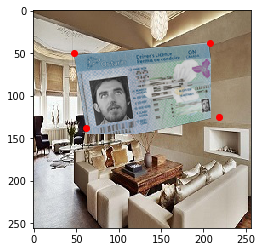

In [0]:
print(shape)
print(shape.num_parts)
print(shape.rect)
print(shape.part(0), shape.part(1), shape.part(2), shape.part(3))

parts_x = []
parts_y = []
for part_idx in range(shape.num_parts):
    parts_x.append(shape.part(part_idx).x)
    parts_y.append(shape.part(part_idx).y)

preview(img_fn, (0, 0, 0, 0), parts_x, parts_y)